In [23]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from src.evaluation import evaluation
from src.indexing import InvertedIndex
from src.classifiers import NaiveBayesClassifier
from src.embedding import create_word_embeddings, apply_lsa
from src.plot import plot_confusion_matrix
from src.preprocessing import preprocess_text

In [2]:
df_pos = pd.read_csv('../dataset/preprocessed/train_pos.csv')
df_neg = pd.read_csv('../dataset/preprocessed/train_neg.csv')
df_pos.sort_values(by=['ID'], inplace=True)
df_neg.sort_values(by=['ID'], inplace=True)
df_train = pd.concat([df_pos, df_neg], ignore_index=True)
df_train.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
df_train

,text,rating
0,Bromwell High is a cartoon comedy. It ran at t...,9
1,"If you like adult comedy cartoons, like South ...",7
2,Bromwell High is nothing short of brilliant. E...,9
3,"""All the world's a stage and its people actors...",10
4,FUTZ is the only show preserved from the exper...,8
...,...,...
24995,"OK, I love bad horror. I especially love horro...",1
24996,To be brutally honest... I LOVED watching Seve...,1
24997,I'm sure that the folks on the Texas/Louisiana...,4
24998,This film has the kernel of a really good stor...,2


In [3]:
df_pos_test = pd.read_csv('../dataset/preprocessed/test_pos.csv')
df_neg_test = pd.read_csv('../dataset/preprocessed/test_neg.csv')
df_pos_test.sort_values(by=['ID'], inplace=True)
df_neg_test.sort_values(by=['ID'], inplace=True)
df_test = pd.concat([df_pos_test, df_neg_test], ignore_index=True)
df_test.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
df_test

,text,rating
0,I went and saw this movie last night after bei...,10
1,My boyfriend and I went to watch The Guardian....,10
2,My yardstick for measuring a movie's watch-abi...,7
3,How many movies are there that you can think o...,7
4,This movie was sadly under-promoted but proved...,10
...,...,...
24995,CyberTracker is set in Los Angeles sometime in...,3
24996,Eric Phillips (Don Wilson) is a secret service...,3
24997,Plot Synopsis: Los Angeles in the future. Crim...,4
24998,"Oh, dear! This has to be one of the worst film...",1


In [4]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [5]:
X_train = df_train['text'].to_list()
y_train = ["positive" if i>5 else "negative"  for i in df_train['rating'].to_list()]
X_test = df_test['text'].to_list()
y_test = ["positive" if i>5 else "negative"  for i in df_test['rating'].to_list()]

# Naive Bayes

In [6]:
inverted_index = InvertedIndex(dataset=df_train)

In [7]:
inverted_index.posting_list = inverted_index.create_posting_list(inverted_index.dataset)
inverted_index.positive_posting_list = inverted_index.create_posting_list(inverted_index.dataset[inverted_index.dataset['rating']>5])
inverted_index.negative_posting_list = inverted_index.create_posting_list(inverted_index.dataset[inverted_index.dataset['rating']<=5])


In [8]:
inverted_index.positive_posting_list[-10:]

[{'word': 'åge', 'docs': [{8712: [184]}], 'df': 1, 'cf': 1},
 {'word': 'æsthetic', 'docs': [{1830: [293]}], 'df': 1, 'cf': 1},
 {'word': 'écran', 'docs': [{11616: [51]}], 'df': 1, 'cf': 1},
 {'word': 'élan', 'docs': [{1078: [260]}, {1904: [90]}], 'df': 2, 'cf': 2},
 {'word': 'émigré',
  'docs': [{3533: [98]},
   {5598: [92]},
   {6907: [55]},
   {7243: [2]},
   {7781: [67]}],
  'df': 5,
  'cf': 5},
 {'word': 'était', 'docs': [{9940: [40, 50]}], 'df': 1, 'cf': 2},
 {'word': 'étc', 'docs': [{3511: [10]}], 'df': 1, 'cf': 1},
 {'word': 'êxtase', 'docs': [{5586: [164]}], 'df': 1, 'cf': 1},
 {'word': 'ís', 'docs': [{6438: [31]}], 'df': 1, 'cf': 1},
 {'word': 'østbye', 'docs': [{8712: [323]}], 'df': 1, 'cf': 1}]

In [9]:
naive_bayes_model = NaiveBayesClassifier(indexing_model=inverted_index)
naive_bayes_model.train()

In [10]:
y_pred = naive_bayes_model.predict(X_train)
evaluation(y_train, y_pred)

{'Accuracy': 0.89748,
 'Precision': 0.9184704792386086,
 'Recall': 0.8724,
 'F1-score': 0.8948426537562056,
 'confusion-matrix': array([[11532,   968],
        [ 1595, 10905]])}

In [11]:
y_pred = naive_bayes_model.predict(X_test)
evaluation(y_test, y_pred)

{'Accuracy': 0.81844,
 'Precision': 0.8581841087015207,
 'Recall': 0.76296,
 'F1-score': 0.8077753779697624,
 'confusion-matrix': array([[10924,  1576],
        [ 2963,  9537]])}

# Word2Vec

In [12]:
word2vec_model = Word2Vec(X_train, vector_size=200, window=20, min_count=1, workers=8, sg=0)

In [13]:
# Create Word Embeddings
X_train_word_embeddings = create_word_embeddings(X_train, word2vec_model.wv)
X_test_word_embeddings = create_word_embeddings(X_test, word2vec_model.wv)

In [14]:
word2vec_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
word2vec_svm_clf.fit(X_train_word_embeddings, y_train)

SVC(C=1, gamma='auto', kernel='linear')

In [15]:
y_pred = word2vec_svm_clf.predict(X_train_word_embeddings)
evaluation(y_train, y_pred)

{'Accuracy': 0.62248,
 'Precision': 0.6201349654739485,
 'Recall': 0.63224,
 'F1-score': 0.6261289811440343,
 'confusion-matrix': array([[7659, 4841],
        [4597, 7903]])}

In [16]:
y_pred = word2vec_svm_clf.predict(X_test_word_embeddings)
evaluation(y_test, y_pred)

{'Accuracy': 0.62312,
 'Precision': 0.6223175965665236,
 'Recall': 0.6264,
 'F1-score': 0.6243521250299019,
 'confusion-matrix': array([[7748, 4752],
        [4670, 7830]])}

# Word2Vec + LSA

In [17]:
X_train_lsa, X_test_lsa = apply_lsa(X_train_word_embeddings, X_test_word_embeddings, n_components=50)

In [18]:
word2vec_lsa_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
word2vec_lsa_svm_clf.fit(X_train_lsa, y_train)

SVC(C=1, gamma='auto', kernel='linear')

In [19]:
y_pred = word2vec_lsa_svm_clf.predict(X_train_lsa)
word2vec_eval = evaluation(y_train, y_pred)
print(word2vec_eval)

{'Accuracy': 0.62248, 'Precision': 0.6201161148595637, 'Recall': 0.63232, 'F1-score': 0.6261585993820803, 'confusion-matrix': array([[7658, 4842],
       [4596, 7904]])}


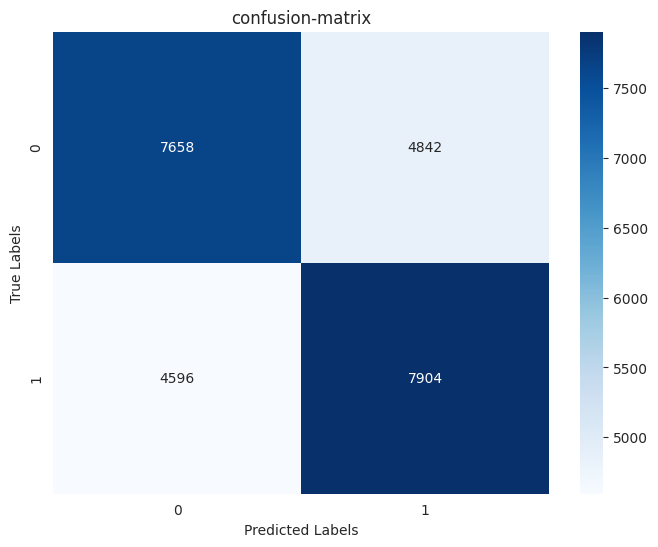

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(word2vec_eval['confusion-matrix'], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('confusion-matrix')
plt.show()

In [26]:
y_pred = word2vec_lsa_svm_clf.predict(X_test_lsa)
word2vec_eval = evaluation(y_test, y_pred)
print(word2vec_eval)

{'Accuracy': 0.62316, 'Precision': 0.6223670614418567, 'Recall': 0.6264, 'F1-score': 0.624377018460189, 'confusion-matrix': array([[7749, 4751],
       [4670, 7830]])}


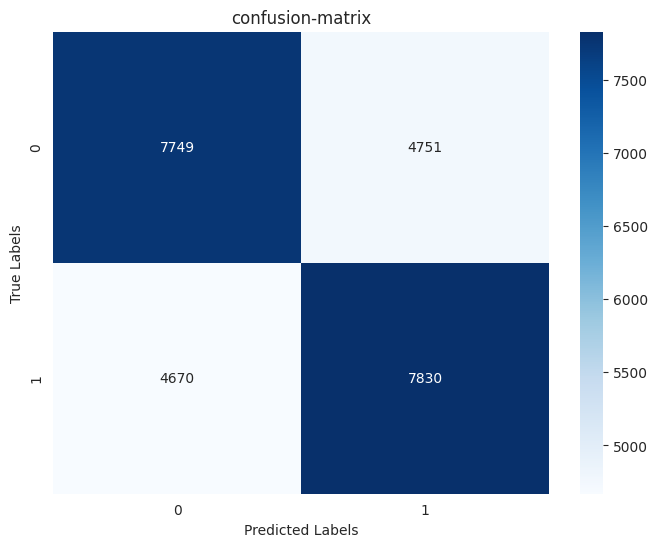

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(word2vec_eval['confusion-matrix'], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('confusion-matrix')
plt.show()